# 300_gpt_tuning_exploration

> In this notebook we will fine-tune several more GPT3.5 models with different numbers of comments. 

In [128]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import openai
import json
from googleapiclient import discovery
from googleapiclient.errors import HttpError


Enable apis with keys. 

In [129]:
with open("C:/Users/danie/OneDrive/Desktop/perspective_api_key.txt") as f:
    api_key = f.readline()

perspective_client = discovery.build(
  "commentanalyzer",
  "v1alpha1",
  developerKey=api_key,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,
)

with open("C:/Users/danie/OneDrive/Desktop/openai_youtube_api_key.txt") as f:
    api_key = f.readline()

openai.api_key = api_key

Set up helper functions:

In [130]:
# Quantifier 
def get_toxicity_score(comment):
    analyze_request = {
        'comment': { 'text': comment },
        'requestedAttributes': {'TOXICITY': {}}
    }
    
    try:
        response = perspective_client.comments().analyze(body=analyze_request).execute()
        return float(response['attributeScores']['TOXICITY']['summaryScore']['value'])
    except HttpError as e:
        return [e.resp.status]

In [132]:
def format_comment_for_finetuning(row):
    affil = row.affiliation
    affil = 'conservative' if affil == 'R' else 'progressive'
    title = row.video_title
    desc = row.video_description
    comment = row.comment_text
    formatted = {"messages": [{"role": "system", "content": f"PunditLLM is a {affil} american pundit who just watched the youtube video '{title}' with the description '{desc}'."}, {"role": "user", "content": "Give your opinion on the video?"}, {"role": "assistant", "content": comment}]}
    return json.dumps(formatted)

In [133]:
def create_training_file(df):
    size = df.shape[0]
    path = f'../data/cleaned/finetuning_research_size{size}_train.jsonl'
    ft_train = open(path, mode='w')

    for i in range(size):
        row_dic = format_comment_for_finetuning(df.iloc[i,:])
        ft_train.write(row_dic)
        ft_train.write('\n')
    
    print(f"Successfully wrote size {size} training file.")
    
    return path

            

In [73]:
comments_df = pd.read_csv("../data/cleaned/channel_subset_with_comments.csv", index_col='comment_id')
comments_df.columns

Index(['channel_id', 'channel_title', 'affiliation', 'video_id', 'video_title',
       'video_description', 'comment_text'],
      dtype='object')

In [74]:
# Right data will be from Turning Point USA
right_comments = comments_df.loc[comments_df.channel_title == 'Turning Point USA']
# Left comments will be from The Young Turks 
left_comments =comments_df.loc[comments_df.channel_title == "TYT's The Conversation"]

print(right_comments.info())
print(left_comments.info())

<class 'pandas.core.frame.DataFrame'>
Index: 21718 entries, UgwObPP6aDo26a1ljL14AaABAg to UgyxikN9LBEXuZiVlj94AaABAg.9HejA80T9UZ9HfsKaGNIJW
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   channel_id         21718 non-null  object
 1   channel_title      21718 non-null  object
 2   affiliation        21718 non-null  object
 3   video_id           21718 non-null  object
 4   video_title        21718 non-null  object
 5   video_description  21718 non-null  object
 6   comment_text       21718 non-null  object
dtypes: object(7)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 3367 entries, Ugy-ppjmdn6c0XdJ1YV4AaABAg to Ugzpilu8e9AhBtMmKZV4AaABAg.9Gk4gGMp-TK9GkC1r3dBtJ
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   channel_id         3367 non-null   object
 1   channel_title      3367 non-null   object
 

Now we will break those down into different size training sets. 

In [75]:
training_sizes = [10, 100, 1000]
created_files = []
for N in training_sizes:
    l = left_comments.sample(n=N)
    r = right_comments.sample(n=N)
    combined = pd.concat([l, r])
    
    created_files.append(create_training_file(combined))
    
print(created_files)

Successfully wrote size 20 training file.
Successfully wrote size 200 training file.
Successfully wrote size 2000 training file.
['../data/cleaned/finetuning_research_size20_train.jsonl', '../data/cleaned/finetuning_research_size200_train.jsonl', '../data/cleaned/finetuning_research_size2000_train.jsonl']


In [76]:
file_api_ids = []
for f,s in zip(created_files, training_sizes):
    train_response = openai.File.create(
        file=open(f, "rb"),
        purpose='fine-tune',
        user_provided_filename=f'v2_train_size{s*2}'
    )
    file_api_ids.append(train_response['id'])


#### Here we go! Let's fine tune some models.

In [77]:
job_ids = []
for f_id in file_api_ids:
    response_1 = openai.FineTuningJob.create(
        training_file=f_id,
        model="gpt-3.5-turbo"
    )
    response_2 = openai.FineTuningJob.retrieve(response_1['id'])
    job_ids.append(response_2['id'])

In [78]:
job_ids

['ftjob-OF0WQ6iELni20Gctq61v0wAr',
 'ftjob-1EDMEwy3uXTwaopHtdH0OR2h',
 'ftjob-CD001PaZrsRc30OW4XF463rJ']

In [79]:
for j_id in job_ids:
    print(openai.FineTuningJob.retrieve(j_id))

{
  "object": "fine_tuning.job",
  "id": "ftjob-OF0WQ6iELni20Gctq61v0wAr",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1697230299,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-4RgDbz9lzSRT5FGez8Jraqy0",
  "result_files": [],
  "status": "validating_files",
  "validation_file": null,
  "training_file": "file-yWBzo6sM2IZoTymCR8EeUfJQ",
  "hyperparameters": {
    "n_epochs": "auto"
  },
  "trained_tokens": null,
  "error": null
}
{
  "object": "fine_tuning.job",
  "id": "ftjob-1EDMEwy3uXTwaopHtdH0OR2h",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1697230300,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-4RgDbz9lzSRT5FGez8Jraqy0",
  "result_files": [],
  "status": "validating_files",
  "validation_file": null,
  "training_file": "file-LaEVU6y2QxYXkmYVqmwwmbRt",
  "hyperparameters": {
    "n_epochs": "auto"
  },
  "trained_tokens": null,
  "error": null
}
{
  "object": "fine_tuning.job",
  "id": "ftjob-CD001PaZrsRc30OW

Interestingly, it appears openai has changed their policy on what type of content you can fine tune models on. It appears, that our largest new dataset failed to fine-tune because of unacceptable comments. Let's see what type of comment fails to pass.

In [80]:
line_numbers = [1311, 1312, 1316, 1330, 1337, 1338, 1342, 1348]
line_numbers_set = set(line_numbers)  # Convert to set for faster lookup
path = '../data/cleaned/finetuning_research_size2000_train.jsonl'
with open(path, 'r') as f:
    for i, line in enumerate(f, start=1):
        if i in line_numbers_set:
            json_obj = json.loads(line)
            print(f"Line {i}: {json_obj}")

Line 1311: {'messages': [{'role': 'system', 'content': "PunditLLM is a conservative american pundit who just watched the youtube video 'Watch This Before You Consider Another Lockdown' with the description 'This Is SO IMPORTANT. You Need To Check Out What Charlie Kirk Is Saying About The Tyrannical Lockdown Orders! #BigGovSucks\n#Conservative #TPUSA #TurningPointUSA #BigGovSucks\n'."}, {'role': 'user', 'content': 'Give your opinion on the video?'}, {'role': 'assistant', 'content': 'In 2020, the flu killed around 24,000 to 62,000 people worldwide. Can you guess how many people died of covid in 2020? 1.8 million people worldwide. So yes, this is “definitely the flu”'}]}
Line 1312: {'messages': [{'role': 'system', 'content': 'PunditLLM is a conservative american pundit who just watched the youtube video \'Candace Owens Nukes A White Liberal With Facts | Do White Liberals Speak For Black Americans?\' with the description \'Candace Owens and Charlie Kirk confront an angry white liberal and 

These do seem like some racy topics and comments. I wonder how they determine what is passable? I can't find exact documentation. Let's do a little bit of exploration on which side these topics are coming from, and their toxicity scores. 

In [90]:
from requests.exceptions import HTTPError

flagged_lines = [6, 8, 9, 10, 12, 14, 16, 20, 24, 28, 32, 33, 35, 41, 44, 45, 46, 51, 52, 64, 65, 66, 69, 72, 81, 82, 85, 96, 104, 108, 112, 113, 114, 125, 131, 135, 136, 139, 150, 153, 154, 157, 163, 164, 185, 189, 192, 198, 199, 207, 219, 221, 224, 234, 239, 243, 244, 247, 248, 251, 252, 255, 260, 266, 268, 269, 270, 273, 274, 275, 280, 284, 285, 287, 290, 307, 313, 314, 321, 330, 331, 334, 337, 339, 340, 343, 344, 345, 350, 351, 352, 353, 357, 358, 359, 364, 366, 368, 372, 373, 374, 379, 380, 384, 392, 393, 394, 398, 407, 410, 413, 417, 424, 425, 435, 439, 440, 442, 449, 451, 453, 454, 458, 464, 466, 473, 478, 481, 485, 515, 523, 526, 538, 540, 545, 546, 548, 558, 559, 561, 563, 564, 565, 566, 571, 578, 581, 595, 602, 606, 613, 617, 618, 625, 638, 643, 644, 648, 652, 657, 671, 673, 678, 679, 690, 697, 700, 702, 706, 713, 715, 720, 723, 726, 729, 730, 751, 752, 754, 760, 762, 766, 767, 768, 772, 781, 785, 786, 788, 790, 792, 794, 800, 804, 807, 809, 811, 816, 823, 829, 831, 836, 841, 843, 846, 852, 853, 859, 866, 870, 872, 874, 875, 879, 890, 891, 895, 907, 908, 910, 912, 913, 919, 925, 928, 935, 936, 937, 947, 960, 963, 982, 985, 990, 995, 996, 1000, 1005, 1006, 1007, 1015, 1017, 1021, 1028, 1030, 1031, 1032, 1039, 1044, 1045, 1051, 1056, 1057, 1060, 1065, 1069, 1070, 1079, 1081, 1083, 1084, 1088, 1094, 1100, 1104, 1105, 1110, 1112, 1113, 1114, 1118, 1121, 1122, 1131, 1135, 1136, 1150, 1151, 1152, 1156, 1157, 1161, 1163, 1167, 1168, 1174, 1176, 1177, 1179, 1186, 1193, 1194, 1198, 1199, 1200, 1203, 1204, 1205, 1215, 1218, 1220, 1225, 1226, 1229, 1230, 1233, 1238, 1239, 1242, 1245, 1254, 1257, 1258, 1260, 1266, 1267, 1272, 1282, 1297, 1299, 1300, 1308, 1311, 1312, 1316, 1330, 1337, 1338, 1342, 1348, 1349, 1356, 1358, 1365, 1367, 1370, 1371, 1373, 1375, 1377, 1378, 1380, 1382, 1383, 1386, 1388, 1389, 1395, 1400, 1401, 1404, 1406, 1411, 1433, 1434, 1435, 1439, 1443, 1447, 1451, 1453, 1461, 1463, 1465, 1470, 1477, 1479, 1490, 1491, 1492, 1494, 1496, 1508, 1516, 1517, 1518, 1521, 1525, 1526, 1534, 1535, 1537, 1542, 1545, 1549, 1550, 1553, 1555, 1557, 1559, 1560, 1561, 1562, 1563, 1564, 1569, 1584, 1585, 1586, 1587, 1591, 1592, 1593, 1597, 1601, 1602, 1606, 1609, 1611, 1612, 1615, 1627, 1628, 1629, 1639, 1640, 1643, 1651, 1653, 1656, 1665, 1669, 1673, 1676, 1680, 1681, 1684, 1690, 1700, 1701, 1707, 1711, 1714, 1721, 1722, 1724, 1729, 1730, 1732, 1735, 1744, 1745, 1746, 1754, 1756, 1757, 1762, 1768, 1769, 1771, 1772, 1775, 1787, 1794, 1799, 1803, 1809, 1810, 1814, 1817, 1822, 1827, 1828, 1831, 1837, 1841, 1846, 1849, 1853, 1854, 1861, 1863, 1864, 1868, 1872, 1874, 1875, 1882, 1884, 1885, 1889, 1897, 1898, 1899, 1901, 1906, 1907, 1920, 1922, 1924, 1925, 1926, 1932, 1935, 1937, 1938, 1939, 1943, 1948, 1949, 1952, 1955, 1967, 1969, 1983, 1992, 1999]
flagged_lines_set = set(flagged_lines)
left_scores = []
right_scores = []
with open(path, 'r') as f:
    for i, line in enumerate(f, start=1):
        if i in flagged_lines_set:
            json_obj = json.loads(line)
            role = 'right' if json_obj['messages'][0]['content'].split(' ')[3] == 'conservative' else 'left'
            text = json_obj['messages'][2]['content']
            score = get_toxicity_score(text)
            if type(score) == list:
                error = score[0]
                score = -1
            if role == 'right':
                right_scores.append(score)
            else:
                left_scores.append(score)
            


In [92]:
np.array(right_scores)[np.where(np.array(right_scores) != -1)[0]]

array([0.48141238, 0.02096063, 0.06579731, 0.29771072, 0.27750343,
       0.39915034, 0.3389984 , 0.4574824 , 0.37955463, 0.09872158,
       0.0248496 , 0.25084448, 0.16765249, 0.7510937 , 0.85333383,
       0.51869136, 0.4826145 , 0.09191322, 0.02390682, 0.43475235,
       0.5779532 , 0.47173777])

In [96]:
num_left_invalid = len(left_scores)
num_right_invalid = len(right_scores)

num_left_assessable = len(np.where(np.array(left_scores) != -1)[0].tolist())
num_right_assessable = len(np.where(np.array(right_scores) != -1)[0].tolist())

mean_toxicity_left = np.mean(np.array(left_scores)[np.where(np.array(left_scores) != -1)[0]])
mean_toxicity_right = np.mean(np.array(right_scores)[np.where(np.array(right_scores) != -1)[0]])

In [97]:
print("Total left invalid lines:", num_left_invalid)
print("Total left lines which could be assessed for toxicity:", num_left_assessable)
print("Average toxicity score for left lines able to be assesed:", mean_toxicity_left)
print()
print("Total right invalid lines:", num_right_invalid)
print("Total right lines which could be assessed for toxicity:", num_right_assessable)
print("Average toxicity score for right lines able to be assesed:", mean_toxicity_right)

Total left invalid lines: 237
Total left lines which could be assessed for toxicity: 135
Average toxicity score for left lines able to be assesed: 0.24766979662222227

Total right invalid lines: 270
Total right lines which could be assessed for toxicity: 22
Average toxicity score for right lines able to be assesed: 0.33939250640909085


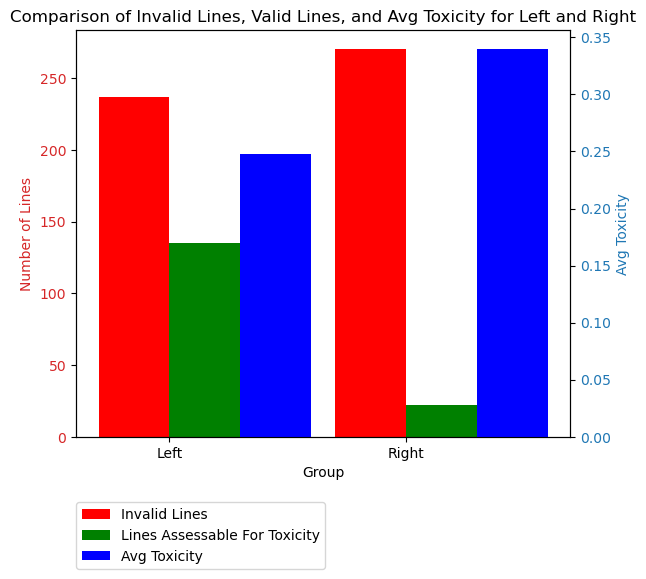

In [108]:
# Bar Chart
labels = ['Left', 'Right']
invalid_counts = [num_left_invalid, num_right_invalid]
valid_counts = [num_left_assessable, num_right_assessable]
avg_toxicity = [mean_toxicity_left, mean_toxicity_right]

x = np.arange(len(labels))

width = 0.3

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Group')
ax1.set_ylabel('Number of Lines', color=color)
ax1.bar(x - width/2, invalid_counts, width, color='r', label='Invalid Lines')
ax1.bar(x + width/2, valid_counts, width, color='g', label='Lines Assessable For Toxicity')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Avg Toxicity', color=color)
ax2.bar(x + width*1.5, avg_toxicity, width, color='b', label='Avg Toxicity')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0))
plt.title('Comparison of Invalid Lines, Valid Lines, and Avg Toxicity for Left and Right')
plt.show()


Since it appears that about half of the comments are not acceptable for GPT fine-tuning we are going to create a deta set 3000 on either side, then upload it and hand pick which comments are acceptable after uploading to create a the 2000 size dataset. 

In [110]:
l = left_comments.sample(n=3000)
r = right_comments.sample(n=3000)
combined = pd.concat([l, r])

size6000_path = create_training_file(combined)

Successfully wrote size 6000 training file.


In [114]:
train_response = openai.File.create(
        file=open(size6000_path, "rb"),
        purpose='fine-tune',
        user_provided_filename=f'v2_train_size{6000}'
)

size6000_file_id = train_response['id']
size6000_file_id

'file-L7EACQIwHOH1NV79hsSTk5Ml'

In [116]:
response_for_size_6000 = openai.FineTuningJob.create(
        training_file=size6000_file_id,
        model="gpt-3.5-turbo"
)

In [119]:
ftjob_response_for_size_6000 = openai.FineTuningJob.retrieve(response_for_size_6000['id'])
ftjob_response_for_size_6000

<FineTuningJob fine_tuning.job id=ftjob-D20R5eCfkaYEkztHhdttf3ct at 0x2228dd64360> JSON: {
  "object": "fine_tuning.job",
  "id": "ftjob-D20R5eCfkaYEkztHhdttf3ct",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1697232789,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-4RgDbz9lzSRT5FGez8Jraqy0",
  "result_files": [],
  "status": "failed",
  "validation_file": null,
  "training_file": "file-L7EACQIwHOH1NV79hsSTk5Ml",
  "hyperparameters": {
    "n_epochs": "auto"
  },
  "trained_tokens": null,
  "error": {
    "code": "invalid_training_file",
    "param": "training_file",
    "message": "The job failed due to an invalid training file"
  }
}

In [120]:
invalid_examples = [1, 4, 6, 17, 20, 22, 36, 45, 49, 68, 71, 75, 77, 80, 90, 97, 106, 114, 120, 121, 130, 137, 141, 142, 146, 152, 153, 159, 160, 163, 164, 168, 170, 172, 191, 193, 205, 209, 210, 212, 234, 237, 240, 241, 250, 252, 253, 261, 262, 265, 272, 274, 277, 278, 279, 282, 288, 302, 310, 314, 317, 319, 325, 327, 334, 338, 351, 358, 359, 360, 368, 374, 378, 379, 380, 385, 386, 389, 391, 392, 412, 415, 419, 430, 437, 439, 440, 447, 455, 456, 460, 464, 467, 475, 479, 484, 493, 499, 505, 509, 517, 531, 538, 540, 543, 546, 547, 548, 549, 550, 553, 556, 565, 571, 582, 586, 593, 614, 615, 620, 622, 625, 635, 638, 642, 643, 646, 651, 652, 659, 662, 667, 669, 674, 681, 689, 698, 702, 709, 728, 729, 730, 747, 750, 764, 766, 768, 772, 782, 785, 786, 787, 795, 806, 816, 817, 821, 823, 828, 835, 850, 855, 856, 862, 863, 865, 868, 875, 877, 881, 885, 886, 889, 890, 897, 899, 903, 905, 908, 914, 915, 916, 925, 930, 937, 946, 948, 950, 955, 957, 958, 963, 967, 969, 974, 975, 983, 985, 988, 990, 991, 993, 994, 1002, 1006, 1010, 1012, 1013, 1014, 1020, 1024, 1026, 1033, 1037, 1040, 1044, 1052, 1064, 1070, 1080, 1082, 1083, 1085, 1098, 1109, 1110, 1111, 1120, 1122, 1127, 1128, 1129, 1139, 1149, 1153, 1155, 1160, 1164, 1167, 1169, 1172, 1174, 1176, 1180, 1184, 1186, 1189, 1190, 1197, 1213, 1214, 1219, 1220, 1222, 1230, 1235, 1242, 1246, 1247, 1248, 1252, 1253, 1258, 1265, 1274, 1282, 1284, 1292, 1293, 1295, 1296, 1302, 1304, 1313, 1316, 1322, 1327, 1332, 1334, 1339, 1340, 1347, 1349, 1352, 1356, 1359, 1362, 1366, 1367, 1368, 1372, 1377, 1392, 1394, 1397, 1405, 1407, 1413, 1423, 1425, 1436, 1439, 1446, 1449, 1452, 1460, 1465, 1466, 1471, 1475, 1494, 1498, 1499, 1500, 1502, 1509, 1515, 1523, 1525, 1527, 1552, 1559, 1562, 1564, 1568, 1580, 1581, 1586, 1589, 1590, 1594, 1596, 1597, 1598, 1599, 1601, 1604, 1606, 1609, 1615, 1619, 1622, 1623, 1625, 1632, 1634, 1635, 1642, 1653, 1657, 1658, 1660, 1663, 1667, 1668, 1680, 1685, 1686, 1691, 1697, 1702, 1706, 1708, 1712, 1717, 1723, 1727, 1734, 1736, 1740, 1742, 1744, 1747, 1751, 1752, 1753, 1756, 1761, 1766, 1769, 1774, 1776, 1781, 1783, 1793, 1794, 1796, 1804, 1806, 1807, 1808, 1811, 1813, 1827, 1829, 1837, 1839, 1840, 1841, 1845, 1848, 1850, 1863, 1865, 1873, 1874, 1894, 1896, 1901, 1906, 1908, 1911, 1913, 1914, 1921, 1924, 1931, 1932, 1934, 1935, 1938, 1940, 1956, 1959, 1969, 1971, 1972, 1980, 1986, 1987, 1994, 1995, 1997, 2002, 2005, 2007, 2009, 2015, 2017, 2021, 2037, 2040, 2041, 2042, 2047, 2053, 2058, 2064, 2069, 2076, 2080, 2082, 2097, 2100, 2108, 2114, 2117, 2133, 2138, 2139, 2150, 2160, 2161, 2163, 2167, 2169, 2172, 2177, 2178, 2180, 2185, 2191, 2208, 2219, 2221, 2226, 2236, 2237, 2243, 2251, 2257, 2262, 2277, 2279, 2284, 2285, 2286, 2287, 2289, 2301, 2303, 2305, 2306, 2310, 2314, 2315, 2317, 2323, 2332, 2335, 2338, 2340, 2341, 2346, 2348, 2351, 2356, 2361, 2368, 2377, 2378, 2383, 2384, 2389, 2390, 2392, 2395, 2396, 2399, 2401, 2404, 2406, 2414, 2417, 2421, 2425, 2434, 2437, 2444, 2446, 2454, 2463, 2468, 2475, 2476, 2477, 2480, 2489, 2495, 2497, 2498, 2499, 2506, 2507, 2512, 2515, 2517, 2518, 2520, 2523, 2525, 2527, 2537, 2544, 2549, 2550, 2552, 2560, 2561, 2563, 2566, 2568, 2575, 2581, 2584, 2601, 2603, 2607, 2609, 2610, 2612, 2615, 2624, 2631, 2640, 2649, 2661, 2667, 2672, 2676, 2697, 2700, 2701, 2704, 2706, 2709, 2713, 2718, 2723, 2726, 2732, 2735, 2738, 2742, 2744, 2745, 2747, 2751, 2766, 2771, 2778, 2786, 2787, 2796, 2797, 2801, 2807, 2810, 2813, 2821, 2831, 2833, 2834, 2840, 2844, 2846, 2849, 2851, 2852, 2854, 2863, 2871, 2873, 2876, 2877, 2885, 2887, 2888, 2889, 2895, 2898, 2901, 2906, 2915, 2919, 2934, 2938, 2943, 2944, 2948, 2956, 2958, 2959, 2960, 2961, 2962, 2970, 2973, 2976, 2982, 2983, 2984, 2986, 2990, 2999, 3000, 3003, 3008, 3010, 3011, 3013, 3016, 3018, 3023, 3027, 3030, 3041, 3042, 3056, 3060, 3061, 3063, 3067, 3068, 3071, 3076, 3079, 3097, 3099, 3104, 3108, 3109, 3110, 3111, 3117, 3121, 3123, 3132, 3133, 3137, 3139, 3147, 3152, 3154, 3163, 3178, 3182, 3186, 3187, 3189, 3193, 3206, 3207, 3214, 3215, 3216, 3225, 3226, 3234, 3246, 3263, 3269, 3280, 3285, 3290, 3297, 3299, 3302, 3305, 3312, 3318, 3321, 3325, 3329, 3333, 3336, 3337, 3343, 3345, 3347, 3349, 3352, 3358, 3367, 3373, 3374, 3382, 3384, 3387, 3390, 3393, 3398, 3400, 3404, 3406, 3410, 3411, 3415, 3417, 3421, 3423, 3428, 3429, 3430, 3431, 3433, 3434, 3440, 3444, 3446, 3447, 3455, 3462, 3468, 3474, 3479, 3480, 3487, 3488, 3490, 3493, 3495, 3496, 3501, 3511, 3512, 3513, 3514, 3520, 3522, 3524, 3525, 3528, 3529, 3530, 3532, 3537, 3539, 3541, 3544, 3548, 3551, 3553, 3554, 3556, 3559, 3561, 3562, 3565, 3566, 3571, 3574, 3577, 3579, 3581, 3587, 3588, 3601, 3606, 3607, 3620, 3624, 3630, 3644, 3645, 3656, 3657, 3670, 3677, 3685, 3686, 3687, 3689, 3698, 3704, 3718, 3720, 3727, 3741, 3753, 3757, 3765, 3771, 3772, 3781, 3791, 3794, 3796, 3799, 3804, 3806, 3813, 3816, 3818, 3822, 3823, 3827, 3830, 3835, 3842, 3854, 3856, 3860, 3861, 3871, 3876, 3879, 3884, 3890, 3897, 3901, 3914, 3918, 3922, 3933, 3935, 3936, 3937, 3938, 3949, 3951, 3952, 3954, 3955, 3958, 3959, 3961, 3962, 3963, 3970, 3972, 3978, 3982, 3983, 3987, 3988, 3992, 3997, 3998, 4000, 4001, 4010, 4016, 4028, 4029, 4030, 4032, 4034, 4041, 4043, 4050, 4062, 4063, 4073, 4077, 4086, 4087, 4088, 4089, 4096, 4100, 4103, 4107, 4111, 4114, 4115, 4116, 4141, 4153, 4162, 4163, 4165, 4171, 4178, 4179, 4182, 4185, 4187, 4194, 4196, 4198, 4200, 4201, 4202, 4208, 4213, 4222, 4223, 4224, 4225, 4228, 4231, 4234, 4235, 4239, 4240, 4241, 4242, 4246, 4249, 4255, 4262, 4264, 4275, 4285, 4294, 4296, 4300, 4302, 4303, 4308, 4321, 4327, 4331, 4334, 4336, 4337, 4348, 4350, 4351, 4355, 4359, 4361, 4368, 4369, 4371, 4374, 4383, 4387, 4389, 4390, 4393, 4397, 4400, 4404, 4405, 4409, 4412, 4419, 4428, 4434, 4438, 4440, 4443, 4454, 4458, 4464, 4469, 4473, 4479]

In [121]:
len(invalid_examples)

1000

In [124]:
with open(size6000_path, "r") as infile, open("../data/cleaned/finetuning_research_size5000_train.jsonl", "w") as outfile:
    for line_number, line in enumerate(infile):
        # If the current line number is not in lines_to_remove, write it to the new file
        if line_number not in invalid_examples:
            outfile.write(line)

In [125]:
train_response = openai.File.create(
        file=open('../data/cleaned/finetuning_research_size5000_train.jsonl', "rb"),
        purpose='fine-tune',
        user_provided_filename=f'v2_train_size5000'
)

size5000_file_id = train_response['id']

response_for_size_5000 = openai.FineTuningJob.create(
        training_file=size5000_file_id,
        model="gpt-3.5-turbo"
)


## For some reason this one worked. 
I have no idea how. And I don't know what the dataset looks like. Because of this, I am going to see if I can fine-tune with a subset of the data and then explore the distribution of comments. If it won't train with a subset, there is a bug in OpenAI's api.

Let's reuse the code above on the dataset that worked.

In [136]:
left_scores = []
right_scores = []
with open('../data/cleaned/finetuning_research_size5000_train.jsonl', 'r') as f:
    for i, line in enumerate(f, start=1):
        json_obj = json.loads(line)
        role = 'right' if json_obj['messages'][0]['content'].split(' ')[3] == 'conservative' else 'left'
        text = json_obj['messages'][2]['content']
        score = get_toxicity_score(text)
        if type(score) == list:
            error = score[0]
            score = -1
        if role == 'right':
            right_scores.append(score)
        else:
            left_scores.append(score)

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

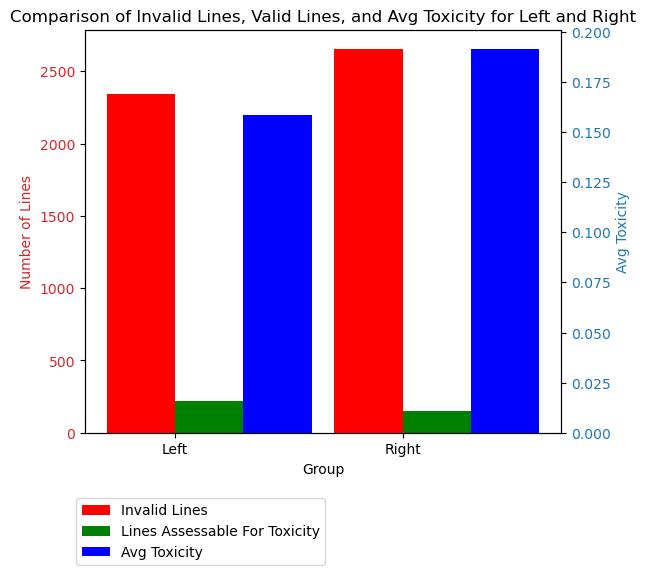

In [137]:

print(right_scores)
num_left_invalid = len(left_scores)
num_right_invalid = len(right_scores)

num_left_assessable = len(np.where(np.array(left_scores) != -1)[0].tolist())
num_right_assessable = len(np.where(np.array(right_scores) != -1)[0].tolist())

mean_toxicity_left = np.mean(np.array(left_scores)[np.where(np.array(left_scores) != -1)[0]])
mean_toxicity_right = np.mean(np.array(right_scores)[np.where(np.array(right_scores) != -1)[0]])

print("Total left invalid lines:", num_left_invalid)
print("Total left lines which could be assessed for toxicity:", num_left_assessable)
print("Average toxicity score for left lines able to be assesed:", mean_toxicity_left)
print()
print("Total right invalid lines:", num_right_invalid)
print("Total right lines which could be assessed for toxicity:", num_right_assessable)
print("Average toxicity score for right lines able to be assesed:", mean_toxicity_right)

# Bar Chart
labels = ['Left', 'Right']
invalid_counts = [num_left_invalid, num_right_invalid]
valid_counts = [num_left_assessable, num_right_assessable]
avg_toxicity = [mean_toxicity_left, mean_toxicity_right]

x = np.arange(len(labels))

width = 0.3

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Group')
ax1.set_ylabel('Number of Lines', color=color)
ax1.bar(x - width/2, invalid_counts, width, color='r', label='Invalid Lines')
ax1.bar(x + width/2, valid_counts, width, color='g', label='Lines Assessable For Toxicity')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Avg Toxicity', color=color)
ax2.bar(x + width*1.5, avg_toxicity, width, color='b', label='Avg Toxicity')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0))
plt.title('Comparison of Invalid Lines, Valid Lines, and Avg Toxicity for Left and Right')
plt.show()


# TODO MAYBE: TEST WITH A 1000 SUBSET OF THE 5000 SET AND SEE IF IT'S ALLOWED. IF IT ISN'T, THERE IS A BUG.

It appears that the file that was trained on approximately even numbers of left and right comments. It appears that the average toxicity of the right comments is slightly higher but nothing agregious on either side, although not many of the comments were able to be scored. 

Next we move on to testing the models in 300_gpt_finetuned_testing.